In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

file = "datasets/neutrino/bnb_WithWire_00.h5"

with h5py.File(file, "r") as f:
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"[dataset] {name}, shape={obj.shape}, dtype={obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"[group]   {name}")
    f.visititems(print_structure)

[group]   edep_table
[dataset] edep_table/energy, shape=(973691, 1), dtype=float32
[dataset] edep_table/energy_fraction, shape=(973691, 1), dtype=float32
[dataset] edep_table/event_id, shape=(973691, 3), dtype=int32
[dataset] edep_table/event_id.seq_cnt, shape=(879, 2), dtype=int64
[dataset] edep_table/g4_id, shape=(973691, 1), dtype=int32
[dataset] edep_table/hit_id, shape=(973691, 1), dtype=int32
[group]   event_table
[dataset] event_table/event_id, shape=(1085, 3), dtype=int32
[dataset] event_table/event_id.seq_cnt, shape=(1085, 2), dtype=int64
[dataset] event_table/is_cc, shape=(1085, 1), dtype=int32
[dataset] event_table/lep_energy, shape=(1085, 1), dtype=float32
[dataset] event_table/nu_dir, shape=(1085, 3), dtype=float32
[dataset] event_table/nu_energy, shape=(1085, 1), dtype=float32
[dataset] event_table/nu_pdg, shape=(1085, 1), dtype=int32
[dataset] event_table/nu_vtx, shape=(1085, 3), dtype=float32
[dataset] event_table/nu_vtx_corr, shape=(1085, 3), dtype=float32
[dataset] ev

In [ ]:
# plane 0 and 1 have 2400 pixels
# plane 2 has 3456
# each plane has 6400 time slices
# so each event has (2400+2400+3456)*6400 pixels in wire_table
n_events = 10
plane_adc = [[],[],[]]
with h5py.File(file, "r") as f:
    wt = f["wire_table"]
    eid_all = wt["event_id"][:]
    change = np.any(eid_all[1:] != eid_all[:-1], axis=1)
    starts = np.concatenate(([0], np.where(change)[0]+1))
    lengths = np.diff(np.concatenate((starts, [len(eid_all)])))

    for i in range(n_events):
        start = starts[i]
        stop = start + lengths[i]

        lp_slice = wt["local_plane"][start:stop, 0]
        adc_slice = wt["adc"][start:stop, :]

        for j in range(3):
            rows = lp_slice==j
            plane_adc[j].append(adc_slice[rows])

plane_adcs = [np.concatenate(l) for l in plane_adc]

for i, arr in enumerate(plane_adcs):
    plane_len = 3456 if i==2 else 2400
    print(f"plane {i} shape: {arr.shape}, {int(arr.shape[0]/plane_len)} events")

plane 0 shape: (24000, 6400), 10 events
plane 1 shape: (24000, 6400), 10 events
plane 2 shape: (34560, 6400), 10 events


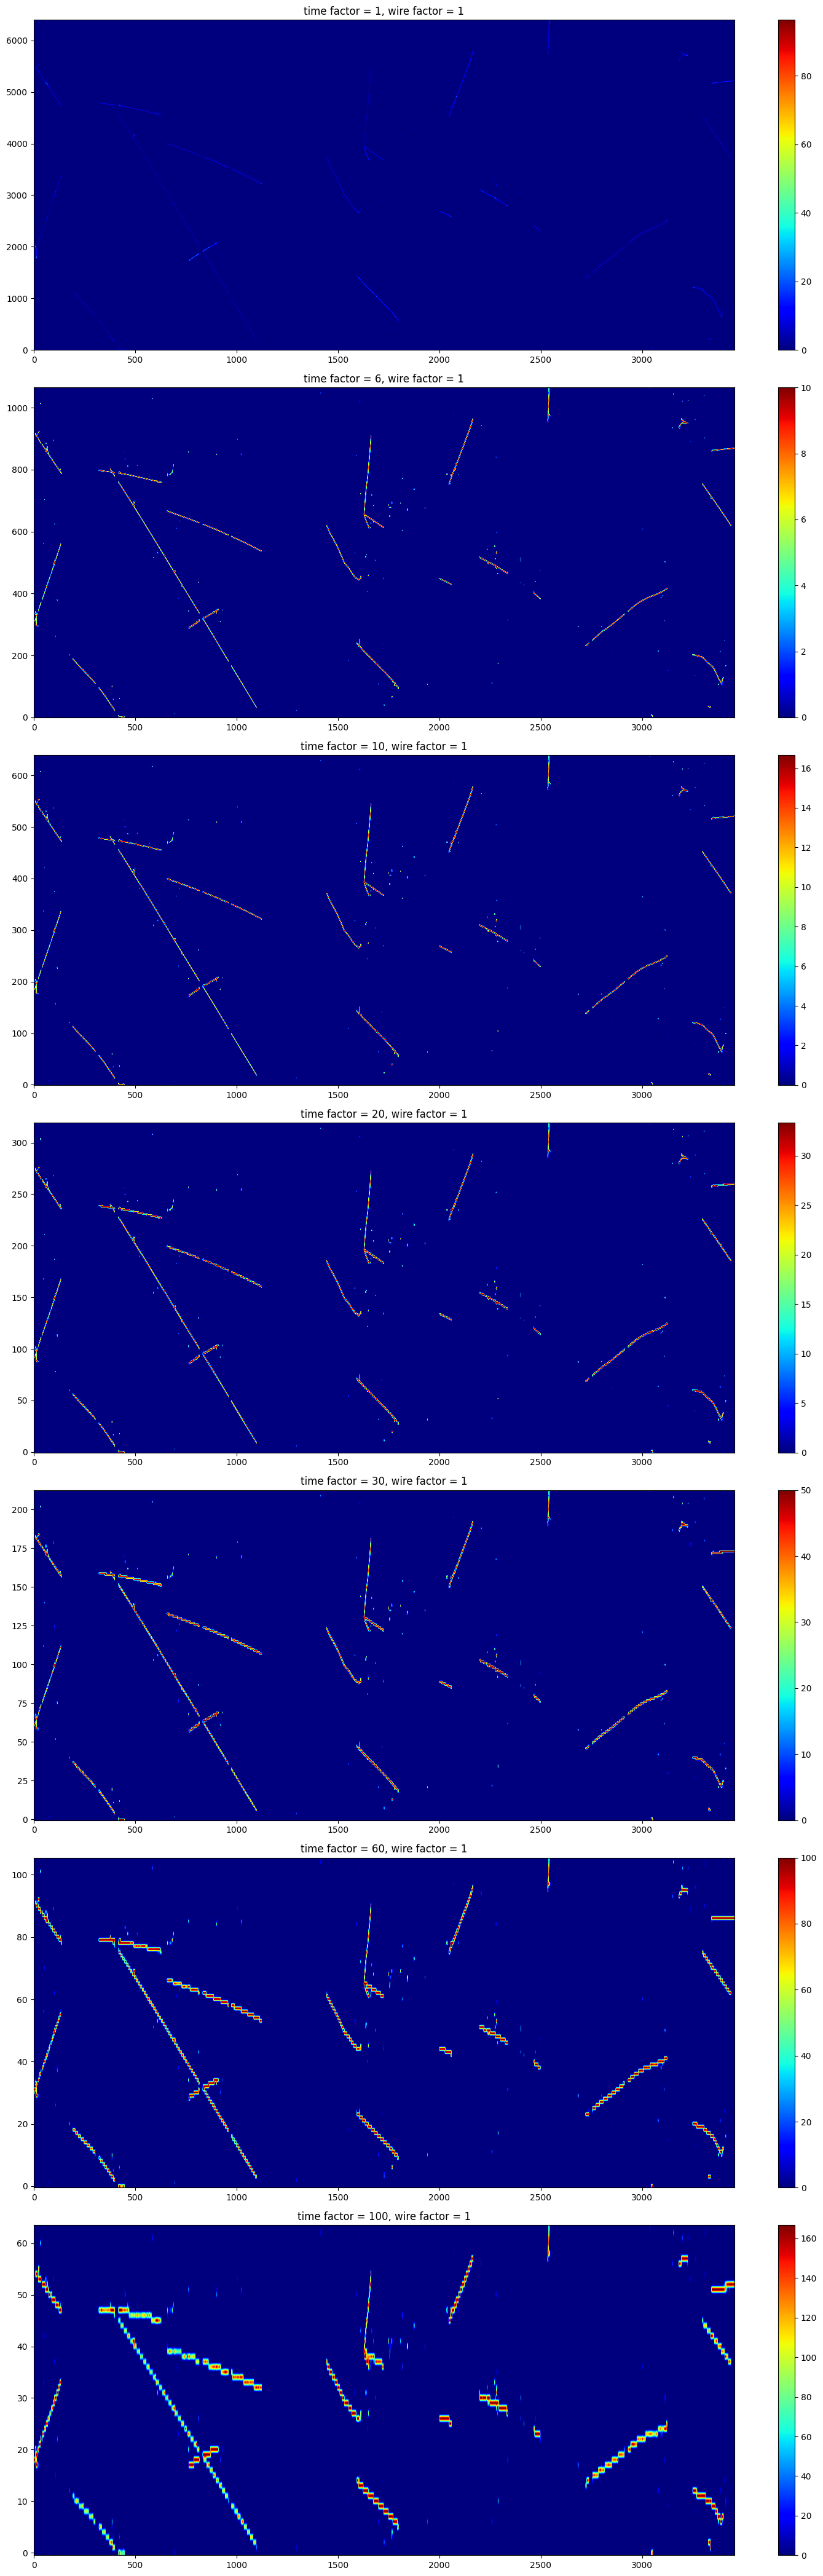

In [28]:
def get_event_plane(arr_plane2, event_idx, wires_per_event=3456):
    start = event_idx * wires_per_event
    return arr_plane2[start : start + wires_per_event]

def downsampling_time(img, factor):
    n_w, n_t = img.shape
    trim = n_t % factor
    if trim:
        img = img[:, :n_t - trim]
    img = img.reshape(n_w, -1, factor).sum(axis=2)

    if factor>1:
        lo = 10 * factor / 60
        hi = 100 * factor / 60
        img = np.where(img < lo, 0, img)
        img = np.clip(img, 0, hi)
    return img

def downsampling_wire(img, factor):
    n_w, n_t = img.shape
    trim = n_w % factor
    if trim:
        img = img[:n_w - trim, :]
    img = img.reshape(-1, factor, n_t).sum(axis=1)

    if factor>1:
        lo = 10 * factor / 20
        hi = 100 * factor / 20
        img = np.where(img < lo, 0, img)
        img = np.clip(img, 0, hi)
    return img

evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 1

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

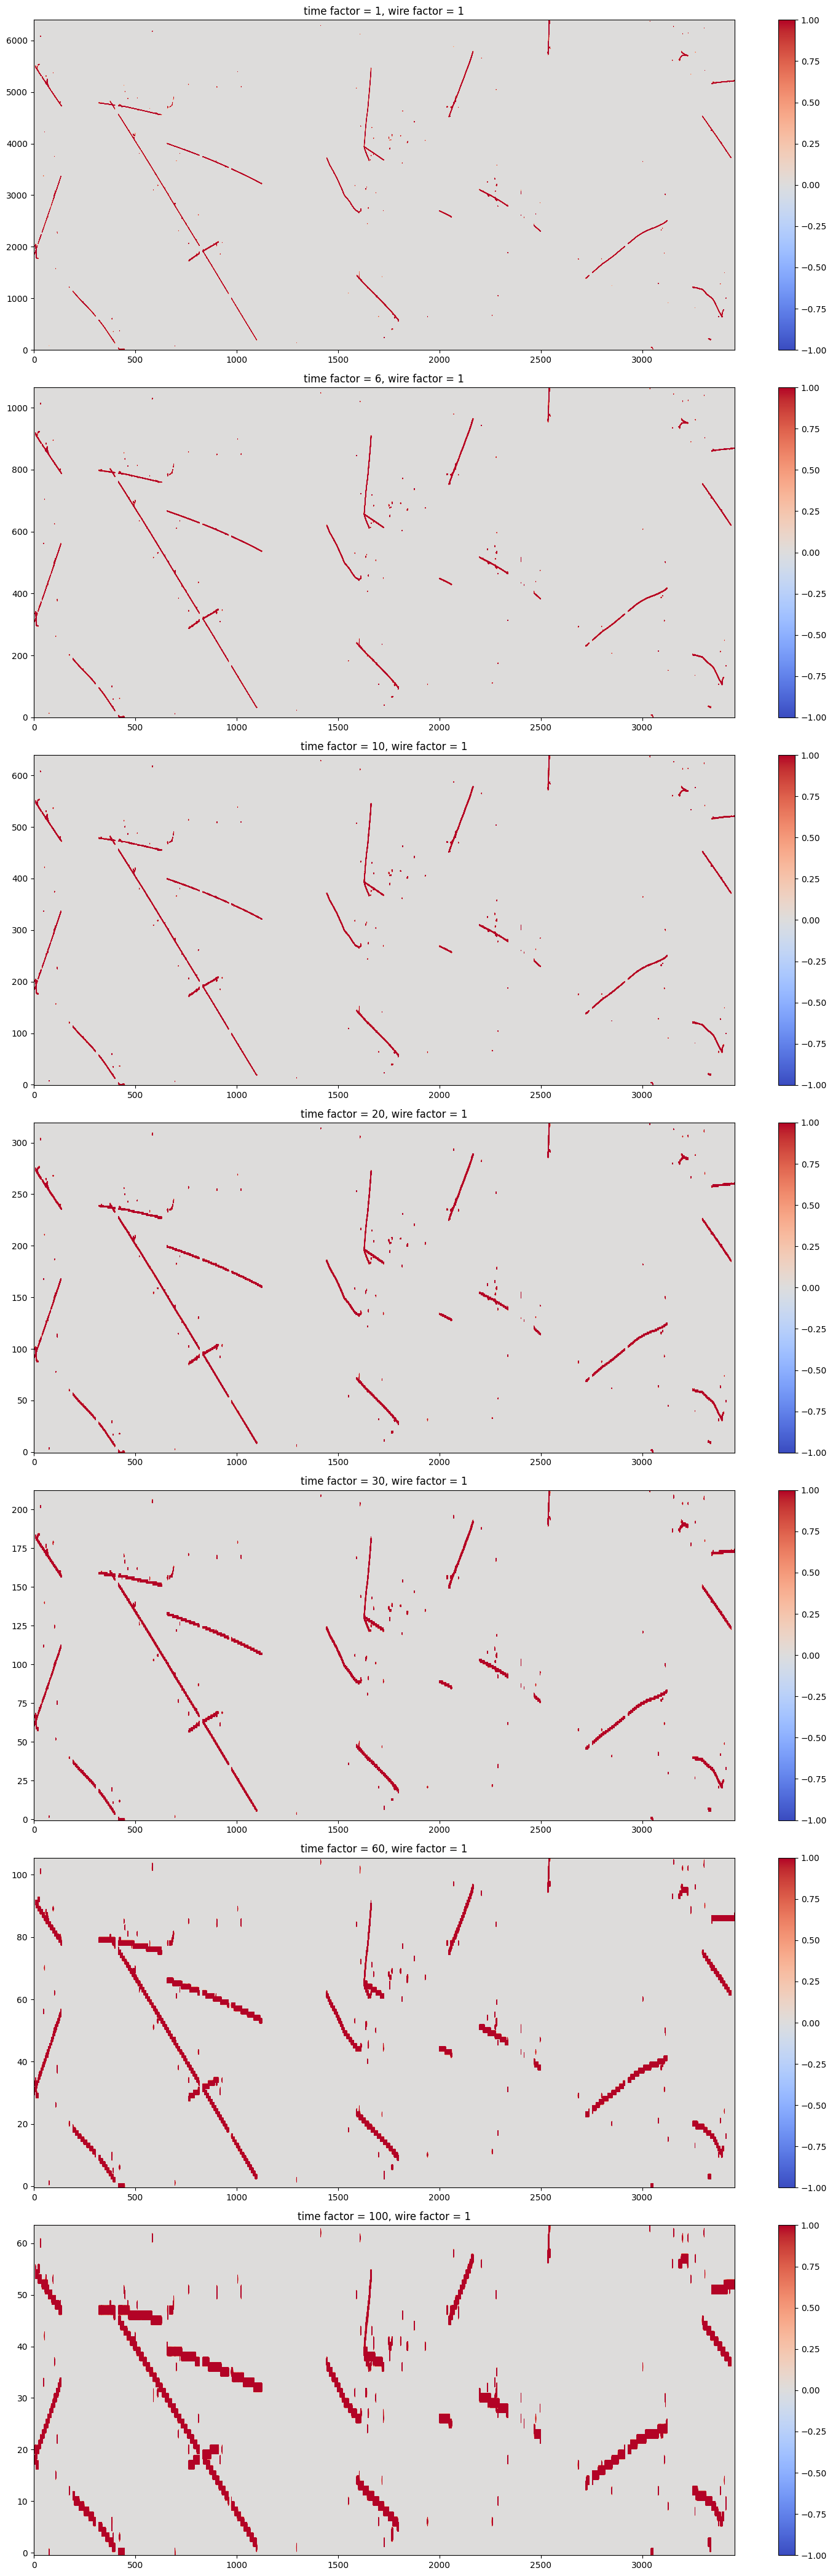

In [29]:
evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 1

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

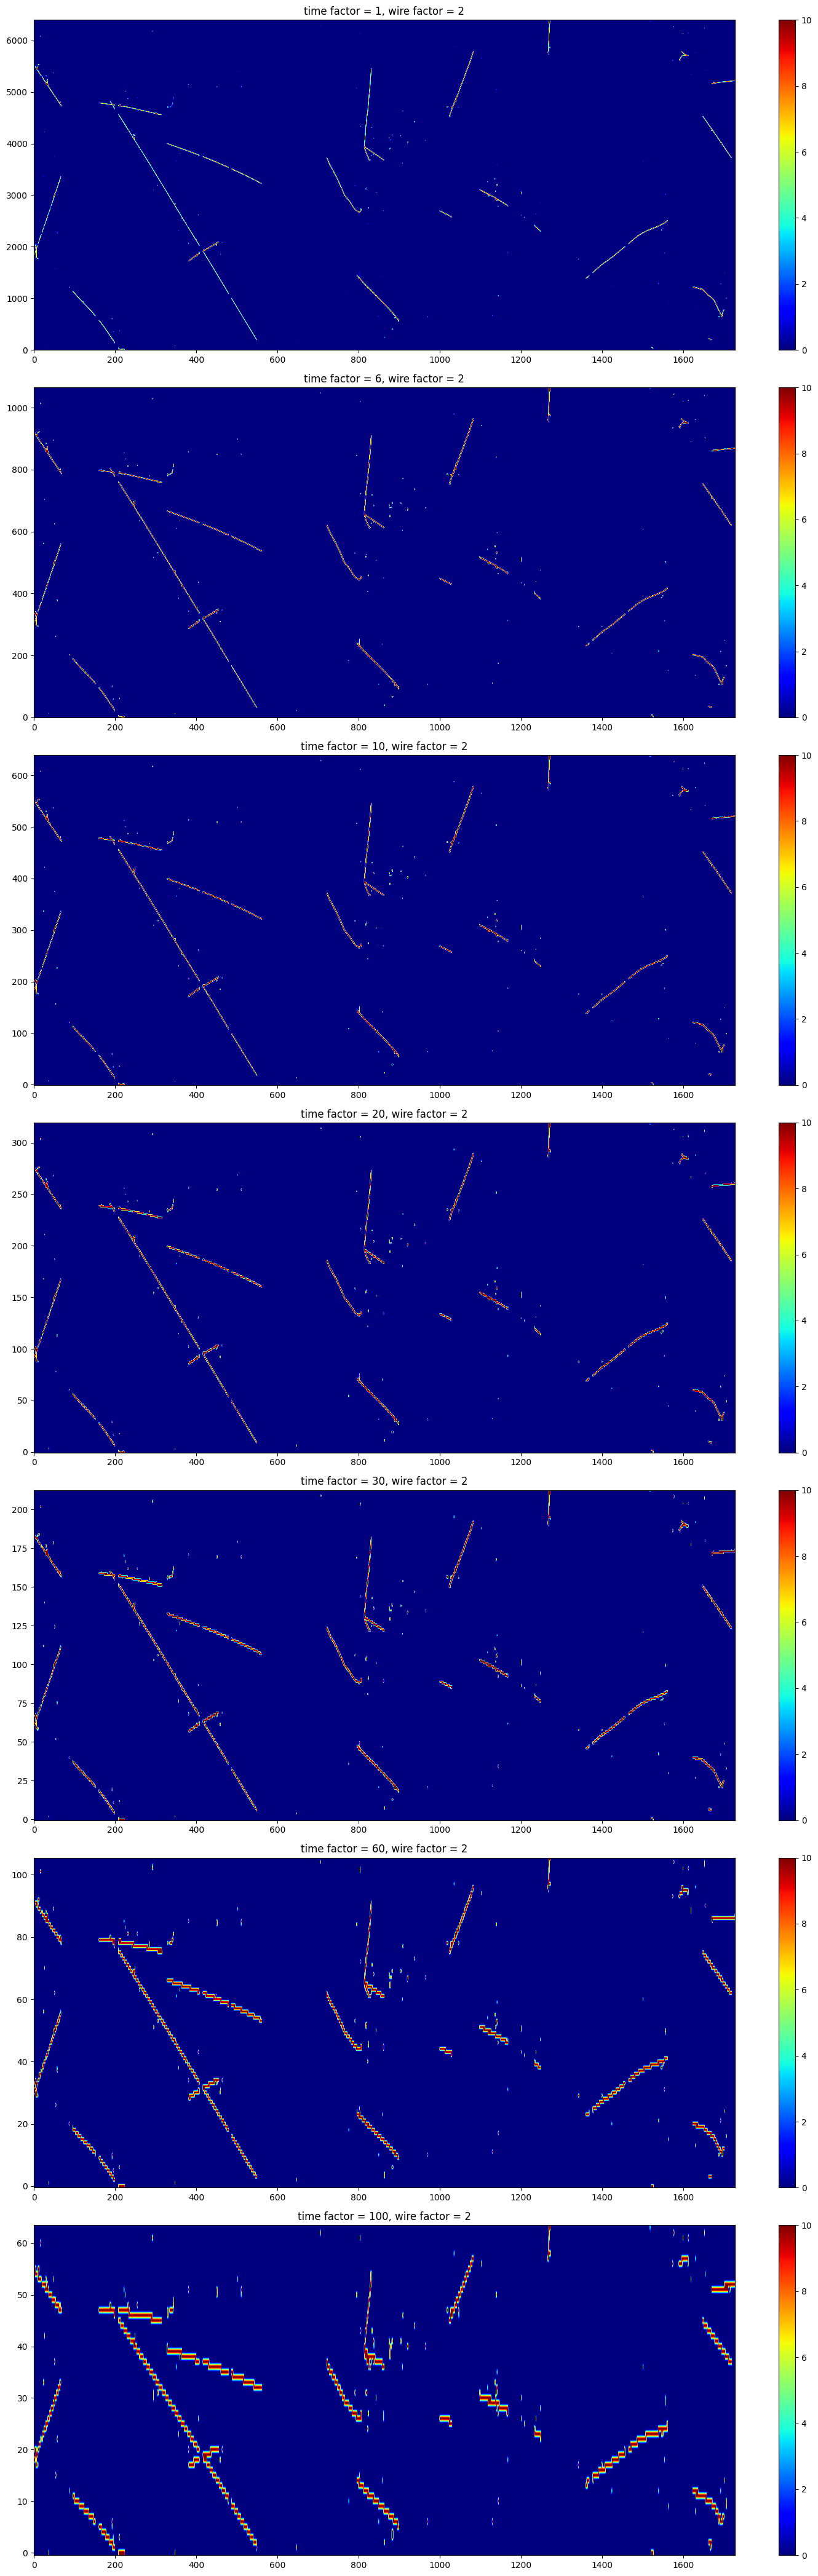

In [32]:
evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 2

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

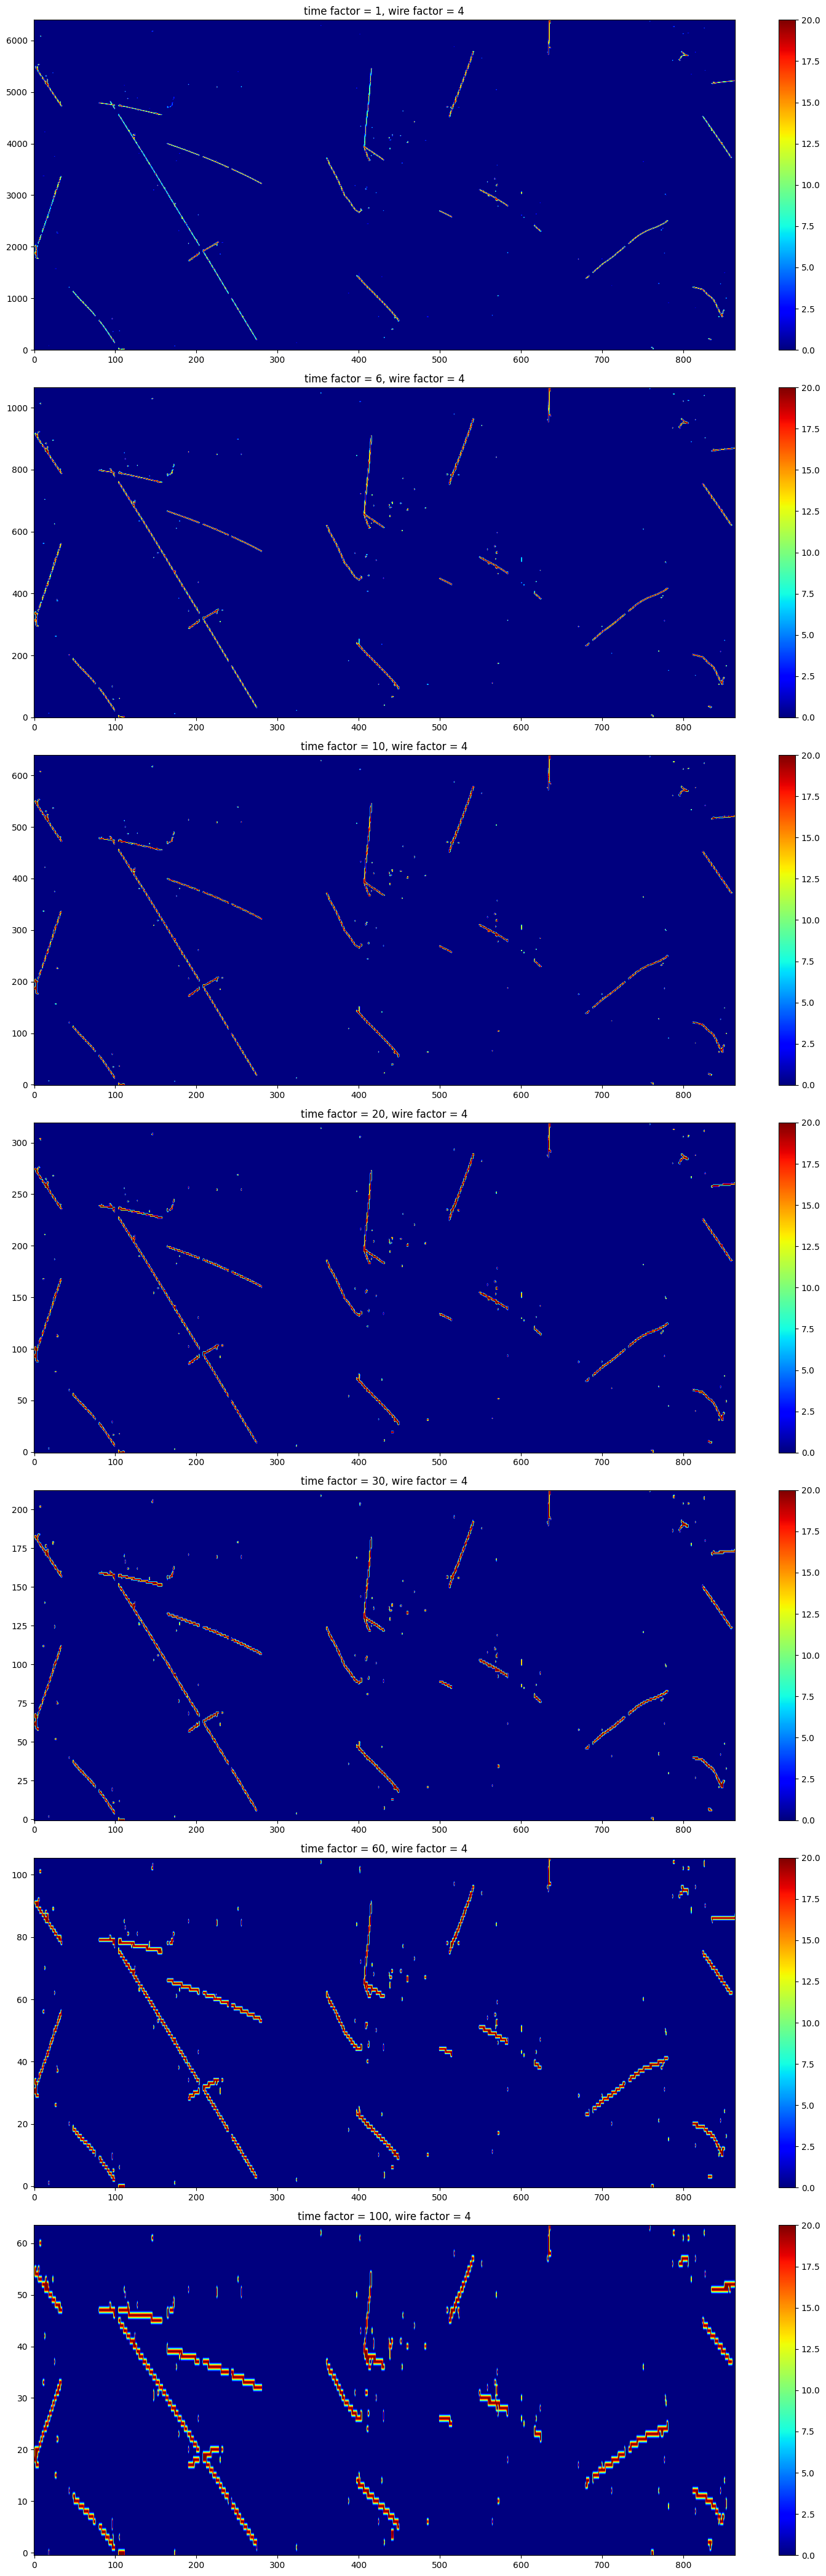

In [33]:
evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 4

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

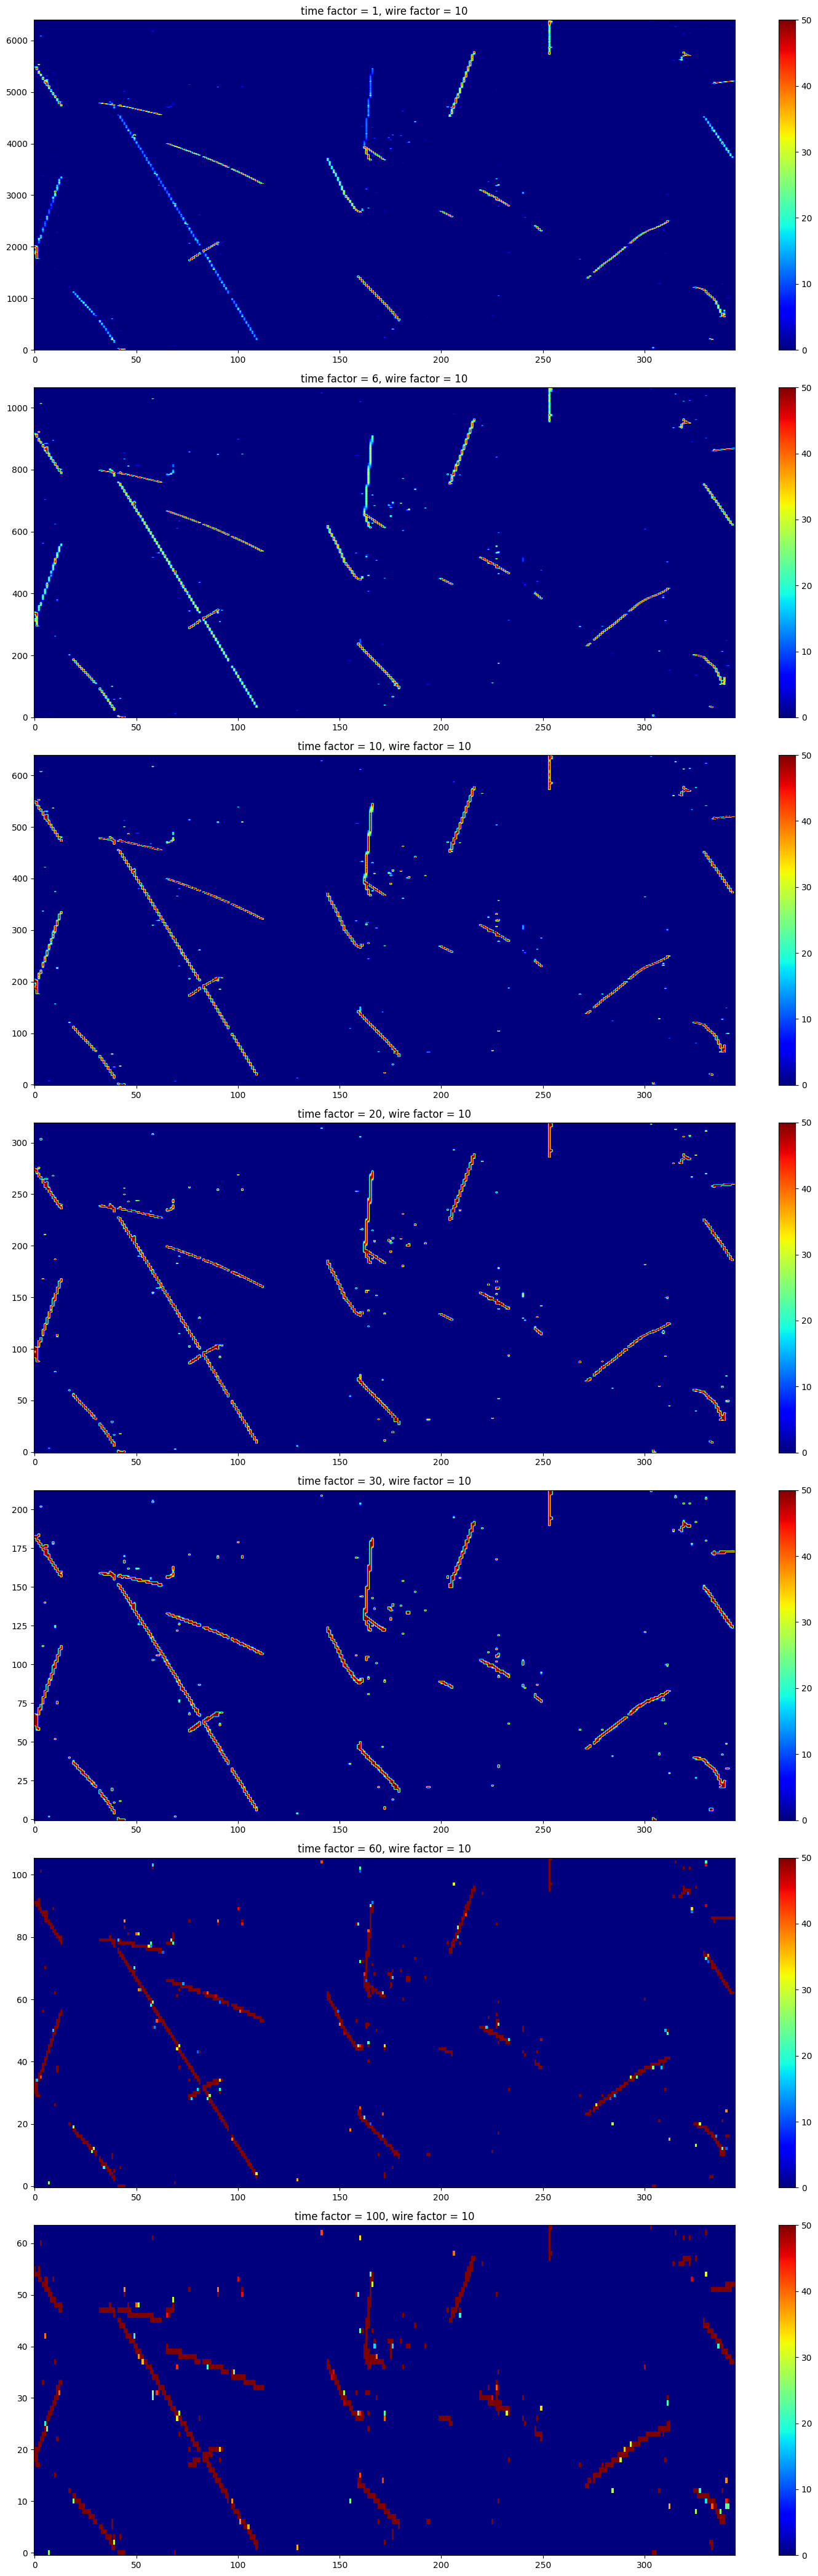

In [34]:
evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 10

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

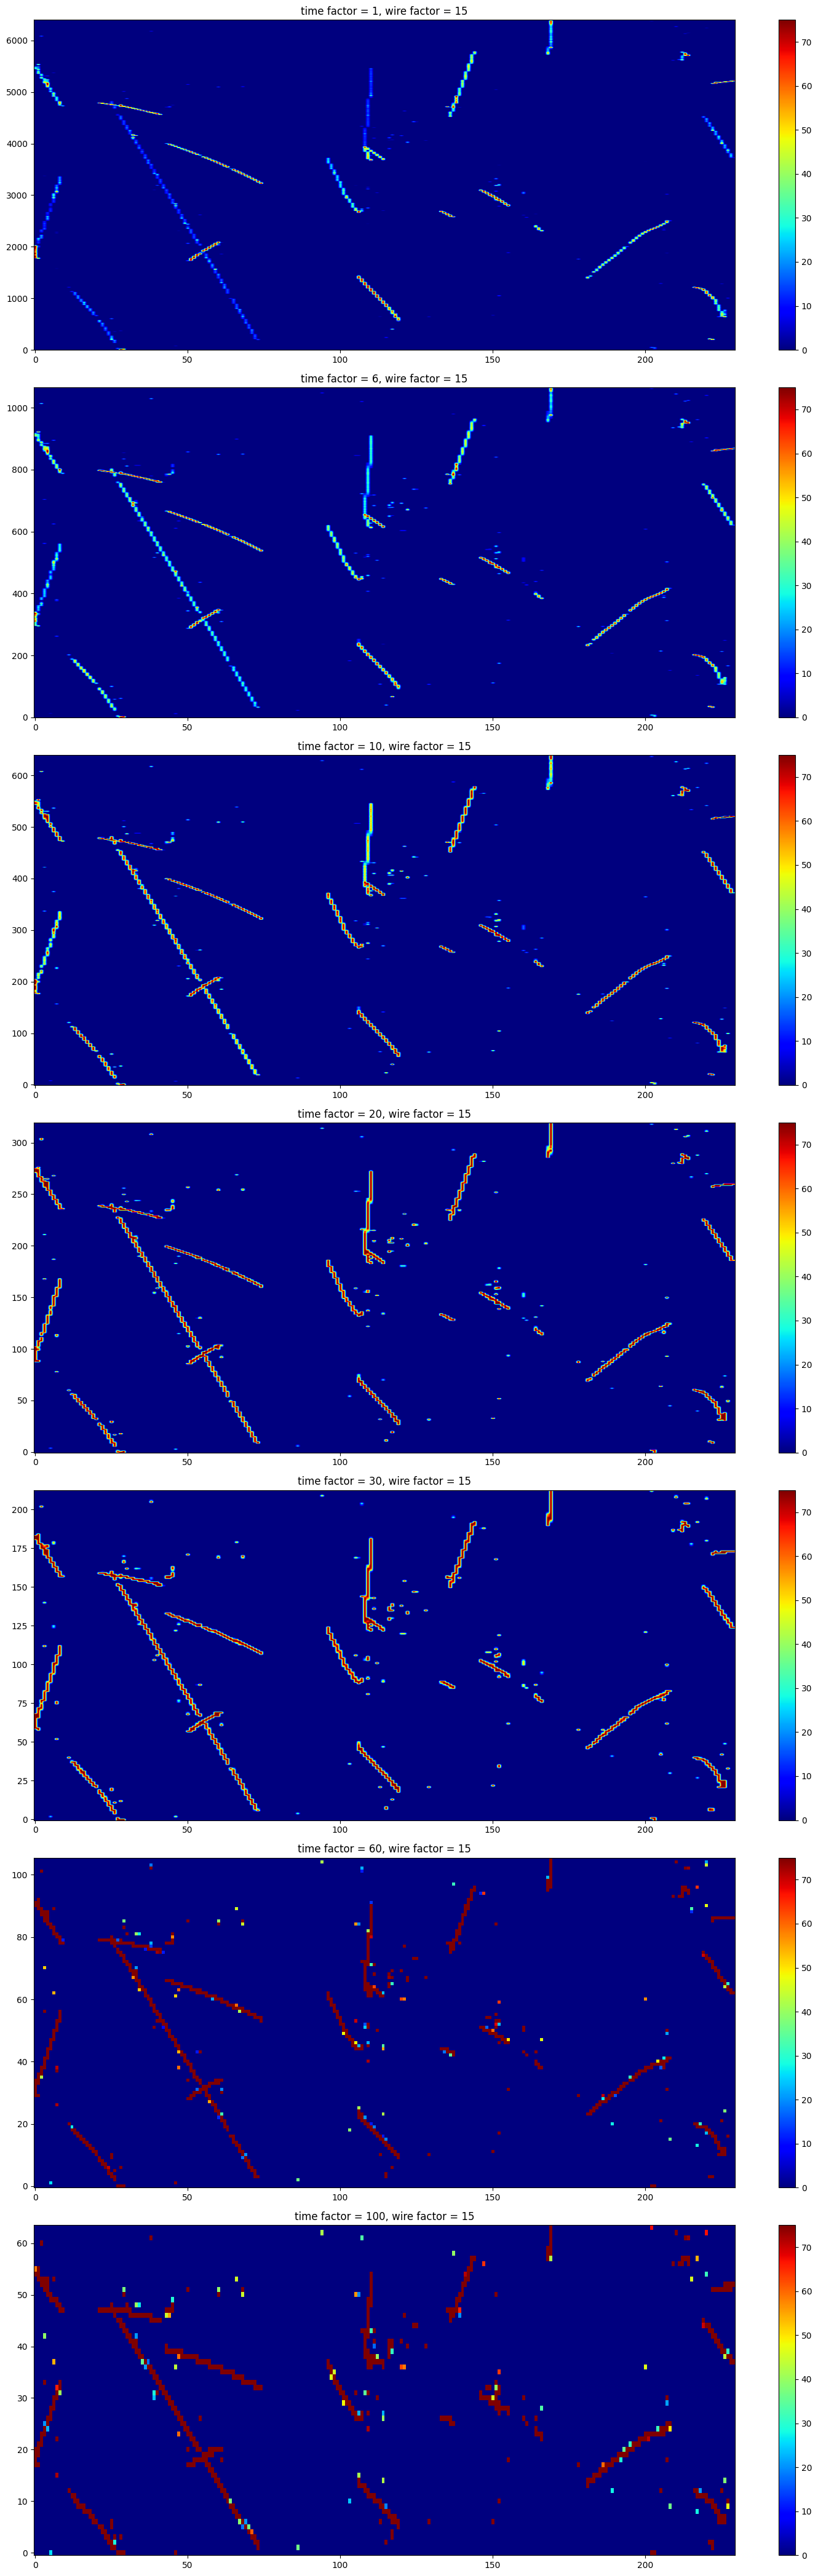

In [35]:
evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 15

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

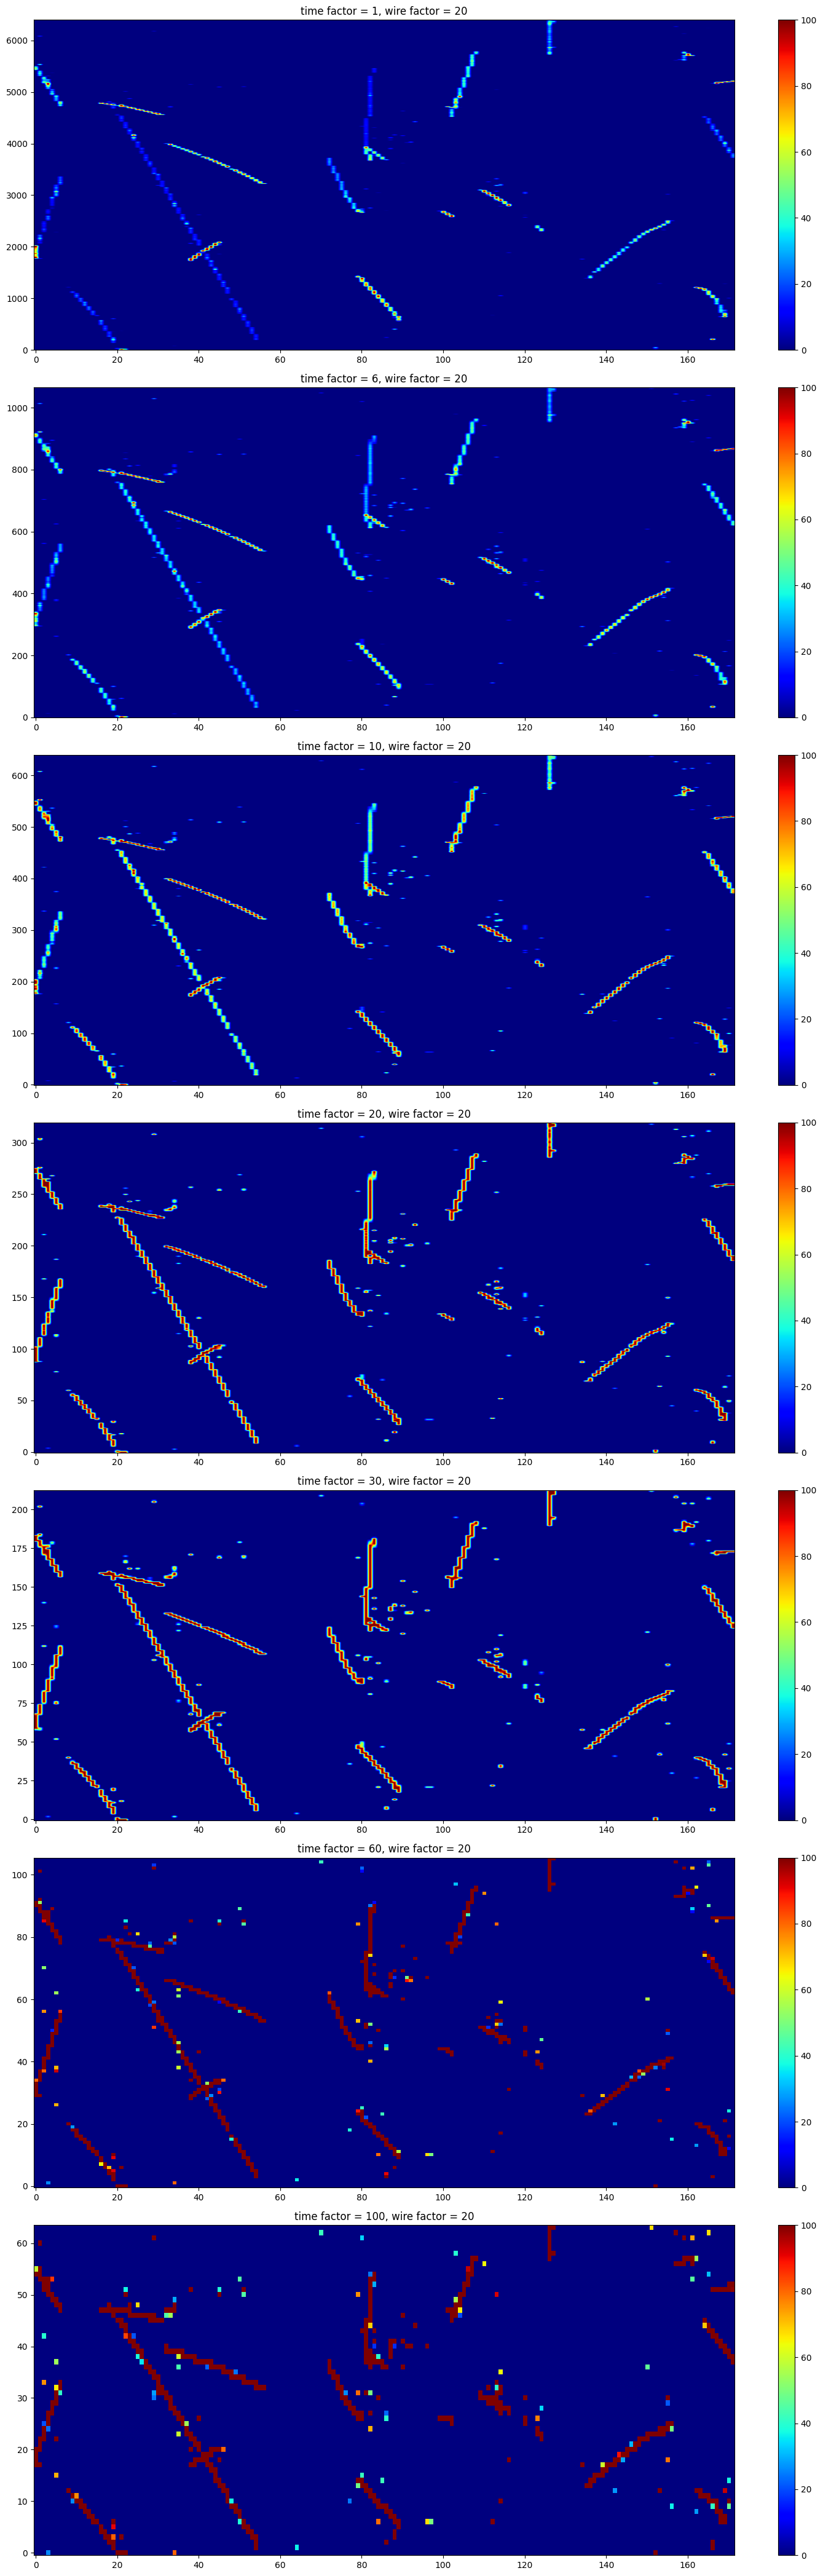

In [36]:
evt_idx = 1 
time_factors = [1, 6, 10, 20, 30, 60, 100]
wire_factor = 20

raw_evt = get_event_plane(plane_adcs[2], evt_idx)

fig, axes = plt.subplots(len(time_factors), 1, figsize=(15, 6*len(time_factors)))
axes = np.atleast_1d(axes)

for ax, time_factor in zip(axes, time_factors):
    img = downsampling_time(raw_evt, factor=time_factor)
    img = downsampling_wire(img, factor=wire_factor)
    im = ax.imshow(img.T, origin='lower', cmap='jet', aspect='auto')
    ax.set_title(f"time factor = {time_factor}, wire factor = {wire_factor}")
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()